# Segmentierung
## Segmentierung mit globalem Schwellwert

In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact

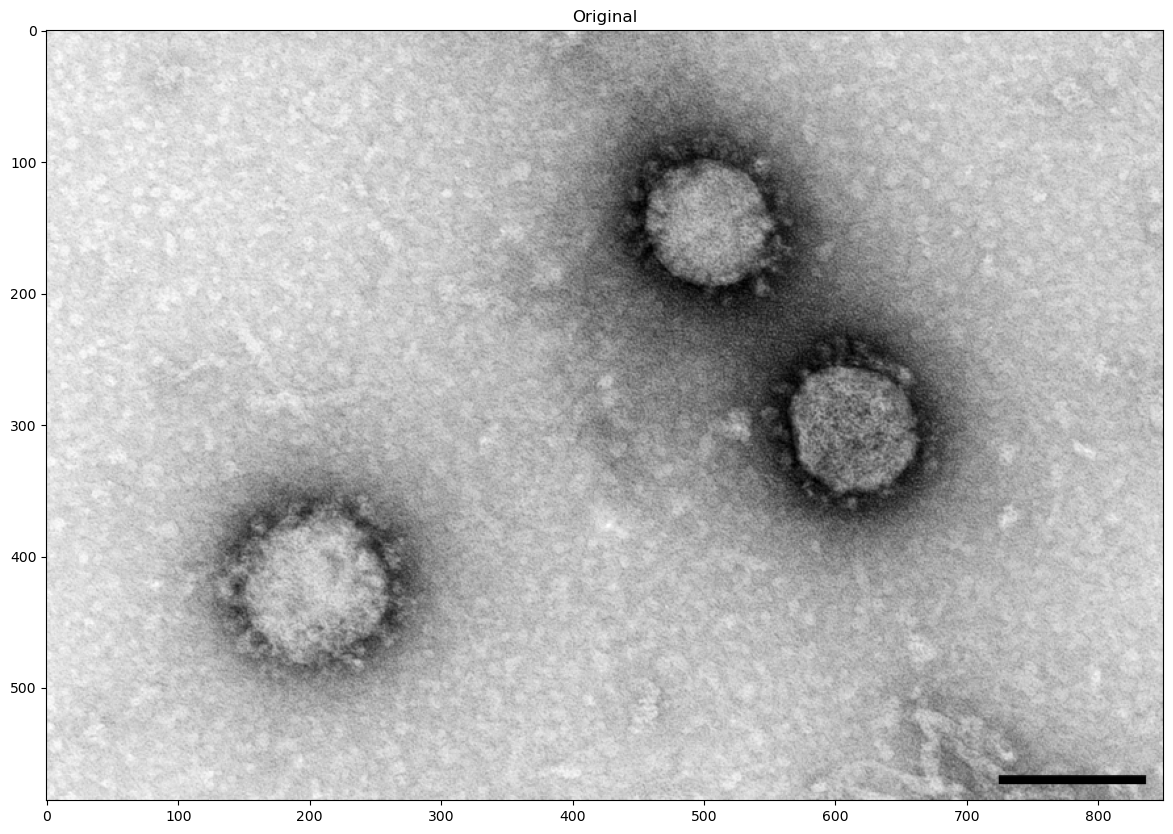

In [2]:
img = cv.imread('./img/SARS_JPG.jpg', cv.IMREAD_GRAYSCALE)
plt.figure(figsize=(20,10))
plt.title('Original')
plt.imshow(img, cmap='gray')
plt.show()

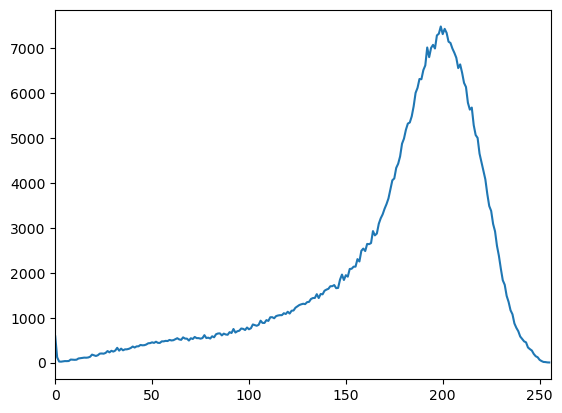

In [3]:
histr = cv.calcHist([img],[0],None,[256],[0,256])
plt.plot(histr)
plt.xlim([0,256])
plt.show()

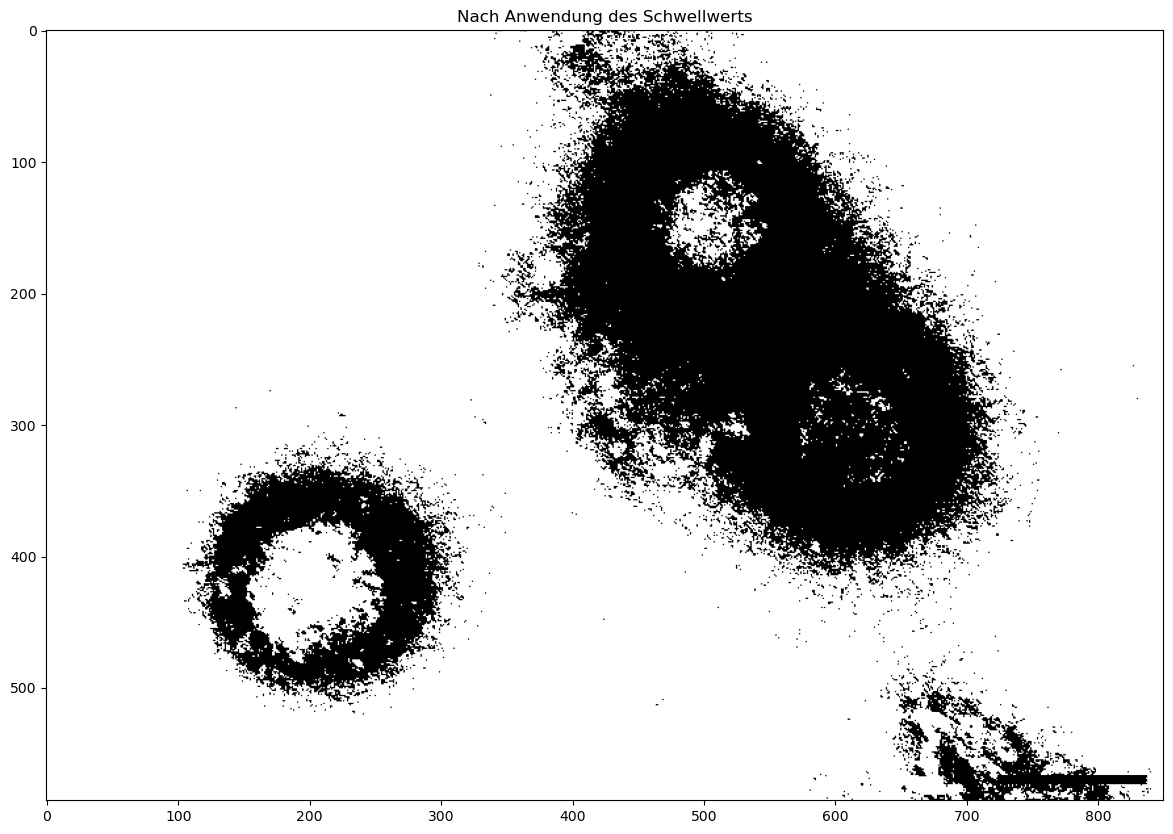

In [4]:
# Schwellwert nach Betrachtung des Histogramms gewählt
thresh = 150
h = len(img[0])
w = len(img)
dst = np.zeros_like(img)

# iteriere über Bild und wende Threshold an
for x in range(w):
    for y in range(h):
        if img[x,y] > thresh:
            dst[x,y] = 255
        else:
            dst[x,y] = 0
            
plt.figure(figsize=(20,10))
plt.title('Nach Anwendung des Schwellwerts')
plt.imshow(dst, cmap='gray')
plt.show()

## Aufgabe: Segmentieren Sie folgendes Bild nach seinen Farbwerten

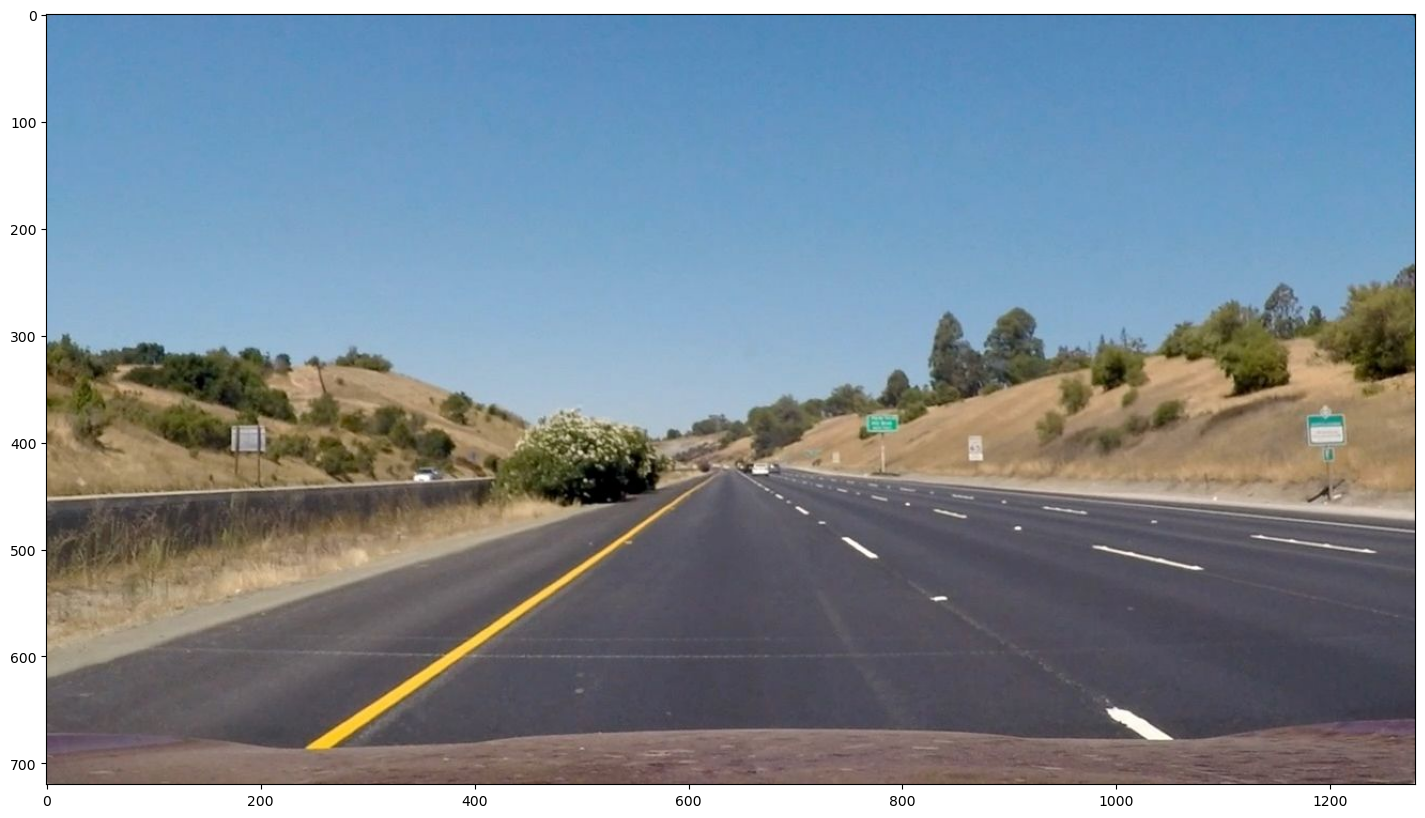

In [5]:
img = cv.imread('./img/image001.jpg', -1)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.show()

# Aufgabe: 
# - berechnen Sie die Farbwerte des Bildes
# - lassen Sie sich das Histogramm darstellen
# - entscheiden Sie anhand des Histogramms, wie Sie den Farbraum segmentieren
# - nehmen Sie die Segmentierung vor

# Segmentierung mit adaptivem vs. globalem Schwellwert

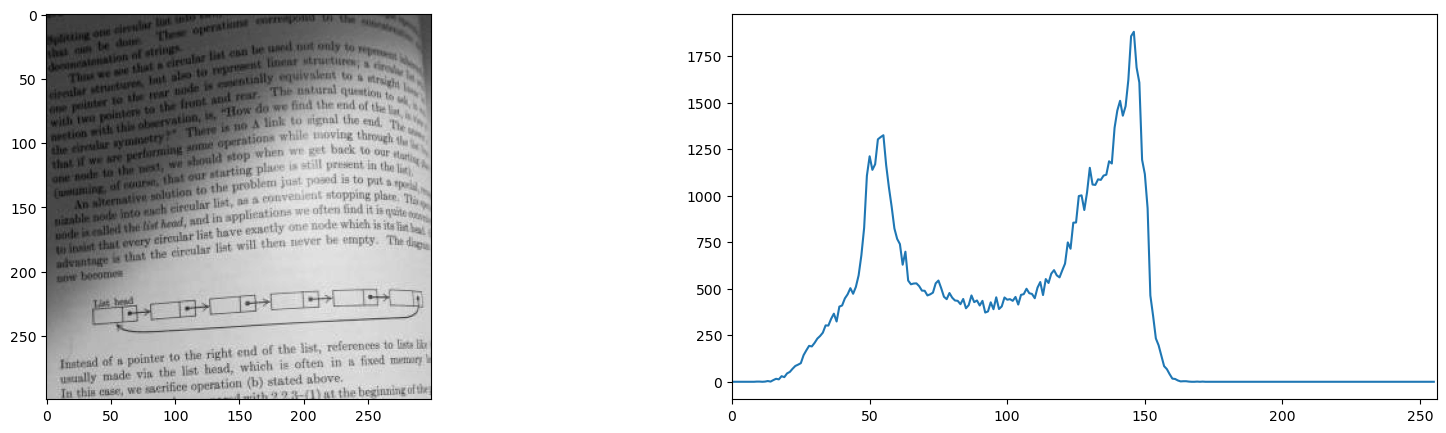

In [6]:
img = cv.imread('./img/bp1.jpg', cv.IMREAD_GRAYSCALE)
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
histr = cv.calcHist([img],[0],None,[256],[0,256])
plt.plot(histr)
plt.xlim([0,256])
plt.show()

## Aufgabe: Wenden Sie den adaptiven Schwellwert an. Welche Unterschiede ergeben sich?

In [7]:
threshold = 90
# wende globalen Schwellwert an und setze alle Pixelwerte > threshold auf 255
ret, thresh_glob = cv.threshold(img, threshold, 255, cv.THRESH_BINARY)

# Nutzen Sie den adaptiven Schwellwert (Mittelwert und Gauß)

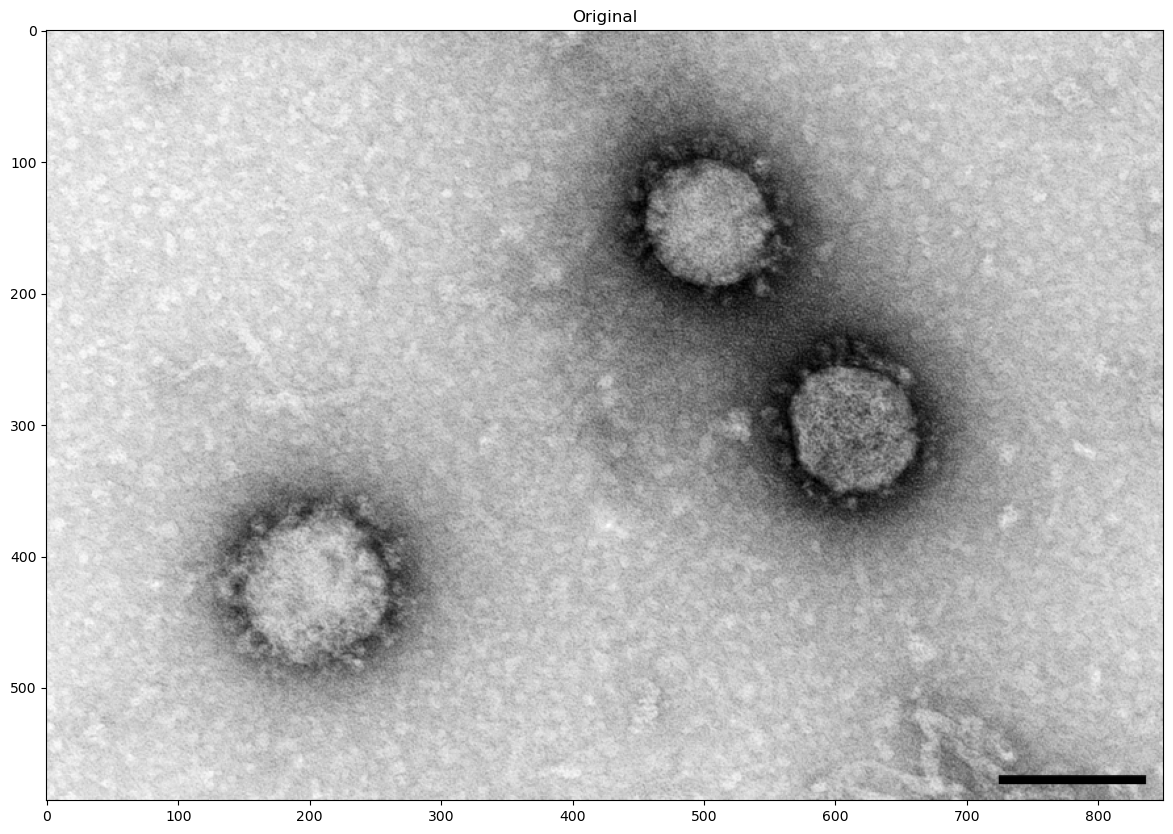

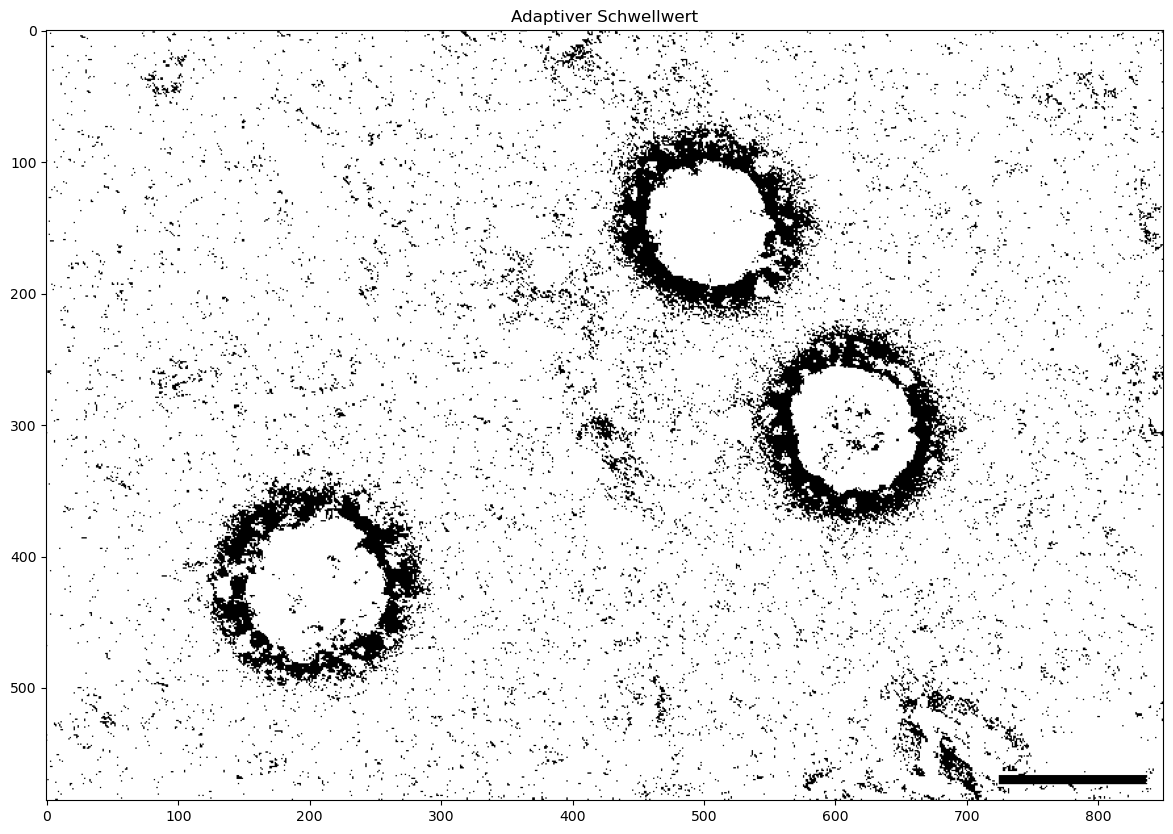

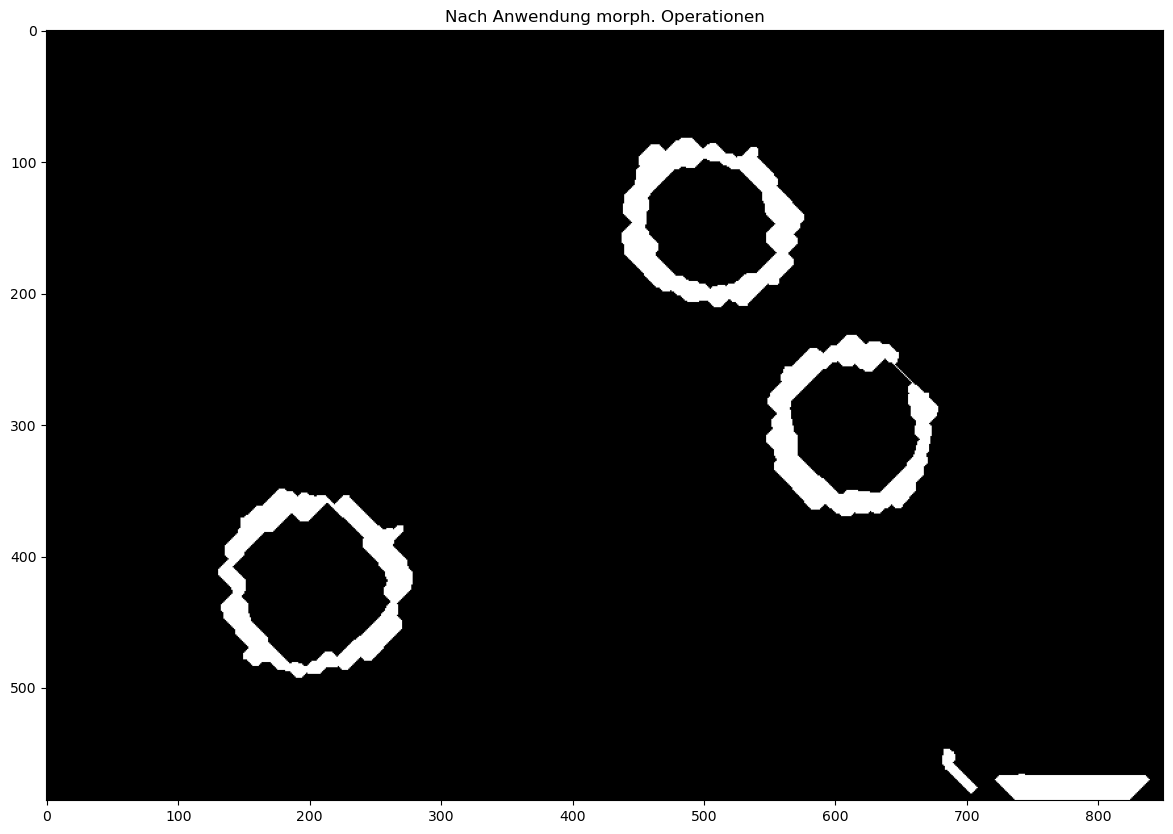

()


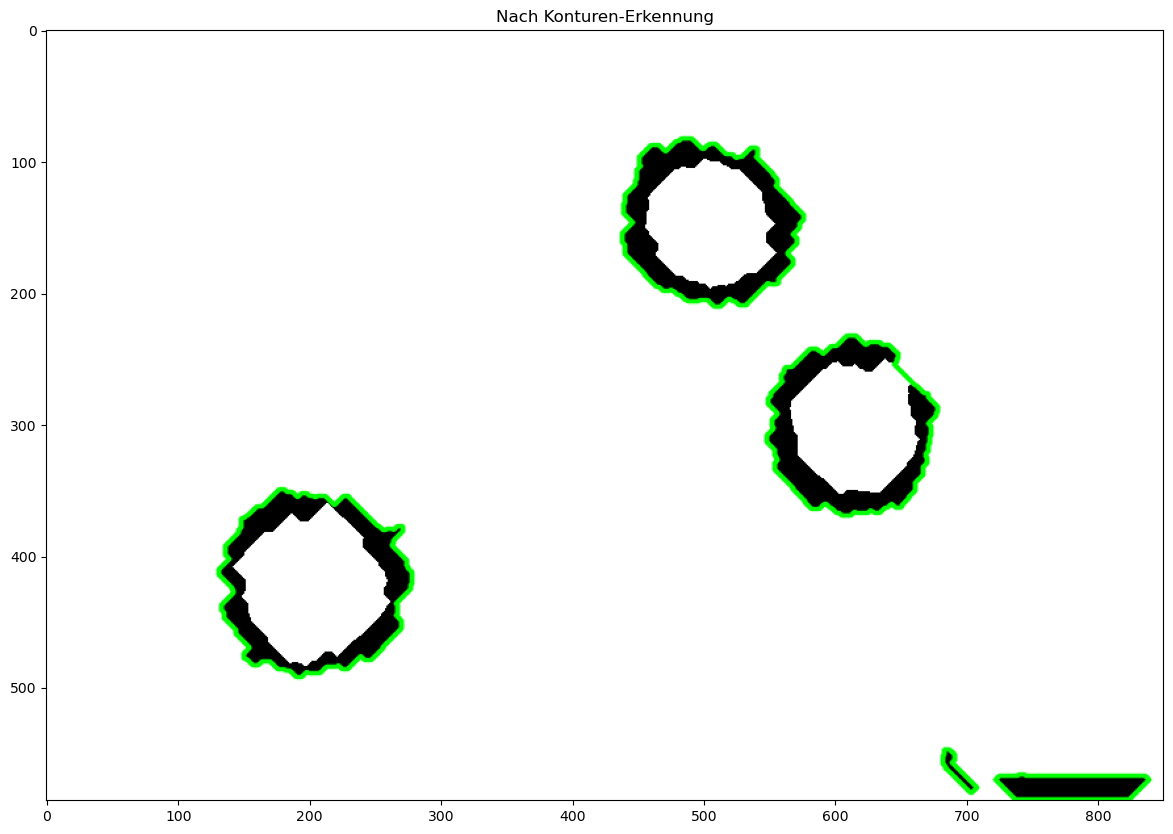

In [8]:
# weiteres Beispiel: Anwendung zur Zellanalyse
img = cv.imread('./img/SARS_JPG.jpg', cv.IMREAD_GRAYSCALE); plt.figure(figsize=(20,10)); plt.title('Original'); plt.imshow(img, cmap='gray'); plt.show()

# Anwendung adapt. Schwellwert
thresh_ada_gauss = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv.THRESH_BINARY, 141, 21)

plt.figure(figsize=(20,10)); plt.title('Adaptiver Schwellwert'); plt.imshow(thresh_ada_gauss, cmap='gray'); plt.show()

kernel_9 = np.ones((3, 3), 'uint8')
kernel_5 = np.array([[0,1,0],[1,1,1],[0,1,0]], 'uint8')
morph_img = cv.morphologyEx(thresh_ada_gauss, cv.MORPH_CLOSE, kernel_9, iterations=2)
morph_img = cv.morphologyEx(morph_img, cv.MORPH_OPEN, kernel_5, iterations=15)
inv_image = cv.bitwise_not(morph_img)

plt.figure(figsize=(20,10)); plt.title('Nach Anwendung morph. Operationen'); plt.imshow(inv_image, cmap='gray'); plt.show()


# Anwendung Blob-Erkennung
blank=np.zeros((1,1))
params = cv.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 20
params.filterByCircularity = False
params.minCircularity = 0.3
detector = cv.SimpleBlobDetector_create(params)
keypoints = detector.detect(morph_img)
print(keypoints)
blobs = cv.drawKeypoints(morph_img,keypoints,blank,(0,255,255),cv.DRAW_MATCHES_FLAGS_DEFAULT)

#plt.figure(figsize=(20,10)); plt.title('Nach Blob-Erkennung'); plt.imshow(blobs); plt.show()
# funktioniert nicht 

# finde Konturen
contours, hierarchy=cv.findContours(inv_image,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_NONE)
cont = cv.cvtColor(morph_img, cv.COLOR_GRAY2RGB)
cont = cv.drawContours(cont, contours, contourIdx=-1, color=(0,255,0), thickness=2, lineType=cv.LINE_AA, hierarchy=hierarchy)
plt.figure(figsize=(20,10)); plt.title('Nach Konturen-Erkennung'); plt.imshow(cont); plt.show()



## Regionsbasierte Segmentierung

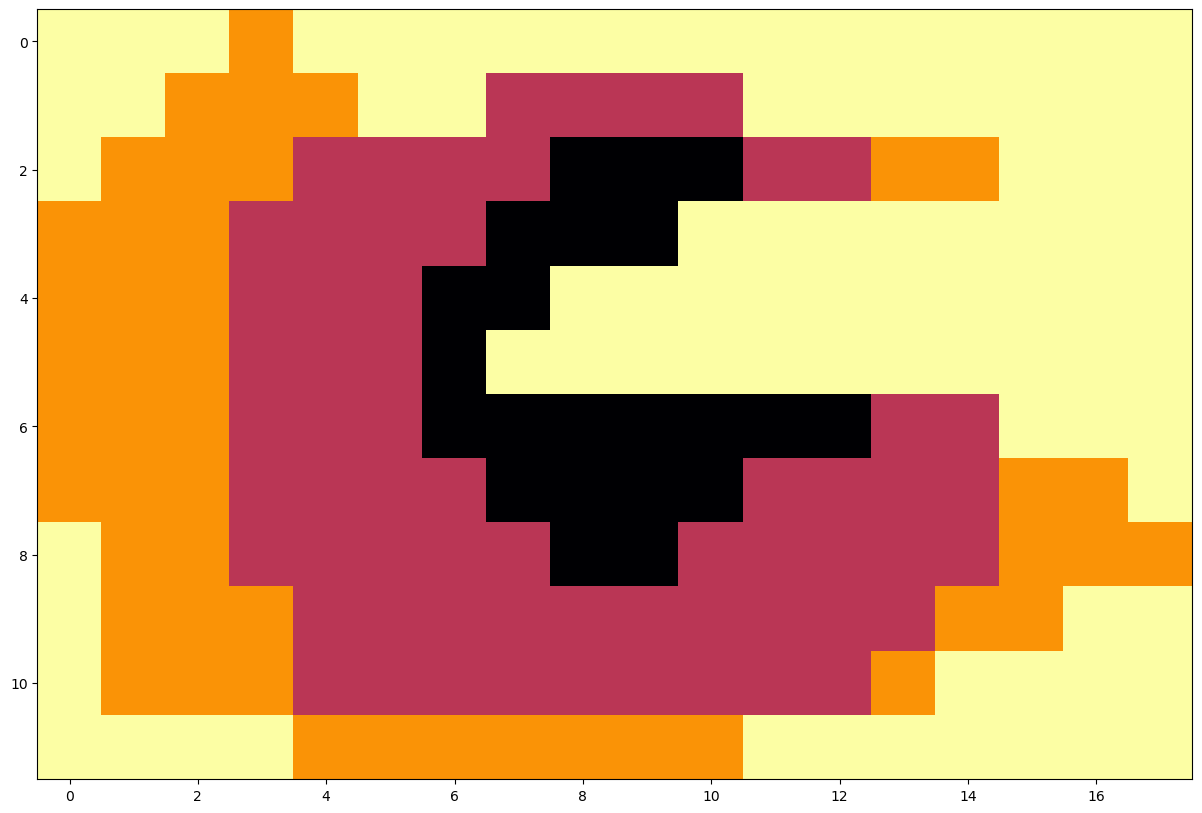

In [9]:
img = cv.imread('./img/image001.jpg', -1)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
# wandle Bild in float um, um höhere Genauigkeit = mehr Farbabstufungen zu erhalten
img_float = np.array(img * 1./255, dtype=np.float32)
img_hsv = cv.cvtColor(img_float, cv.COLOR_RGB2HSV)
img_hue = img_hsv[:,:,0]
img_hue = cv.imread('./img/raw_gray.png', cv.IMREAD_GRAYSCALE)

plt.figure(figsize=(20,10))
plt.imshow(img_hue, cmap='inferno')
plt.show()

iter = 0

check  [4 1]


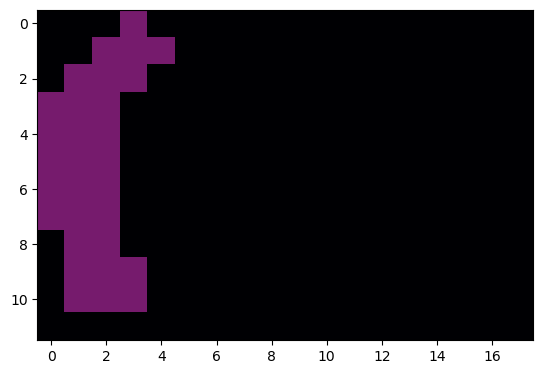

check  [4 5]


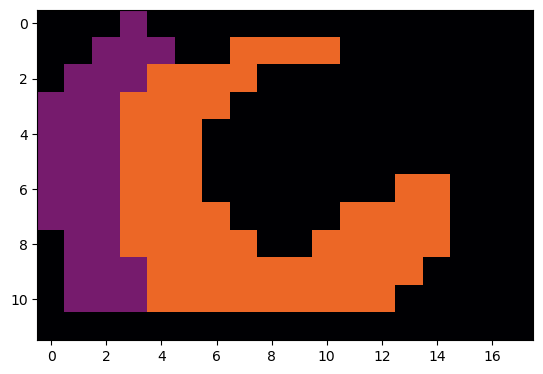

check  [4 6]


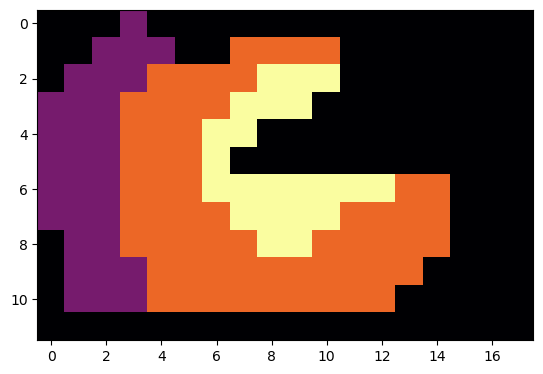

In [10]:
def check_neighborhood(img, init_pt, checked, out, threshold = 1, segment_id = 1): 
    global iter
    iter+=1

    w = len(img[0])
    h = len(img)
    
    # output image (0: does not belong to segment with init_pt, 1: does belong)         
    checked[init_pt[0], init_pt[1]] = 1    
    out[init_pt[0], init_pt[1]] = segment_id
    
    #direction = [[-1,-1],[-1,0],[-1,1],[0,-1],[0,1],[1,-1],[1,0],[1,1]]
    direction = [[-1,0],[0,-1],[0,1],[1,0]]
    neighbors = direction+np.array(init_pt)
    # beschränke die x-Koordinate auf gültige Werte [0..w-1] und y entsprechend auf [0..h-1]
    neighbors[:,0] = np.clip(neighbors[:,0], 0, h-1)
    neighbors[:,1] = np.clip(neighbors[:,1], 0, w-1)
    
    for nb in neighbors:
        # gehört Nachbar noch zu keinem Segment (Ausgang = 0) 
        if(out[nb[0],nb[1]] == 0):
            # ist Pixeldifferenz zur Segmentfarbe < Schwellwert? 
            # falls ja: setze img[x,y] = 1
            # Konvertierung von uint in int aufgrund Datenverlust
            if(np.abs(int(img[nb[0], nb[1]]) - int(img[init_pt[0], init_pt[1]])) < threshold):
                out[nb[0], nb[1]] = segment_id
                filename = './img/out/reg_' + str(iter) + '.bmp'
                cv.imwrite(filename, out)

                # sofern Nachbarschaft des Nachbarn noch nicht geprüft wurde, ruf Prüfung rekursiv auf
                if(checked[nb[0],nb[1]] == 0):
                    checked, out = check_neighborhood(img, nb, checked, out, threshold, segment_id)                        
    
    return checked, out
    
# initialisiere Startpunkte (hier manuell)
seed = np.zeros_like(img_hue)
#seed[501, 761] = 200
#seed[620, 350] = 200
#seed[620, 350] = 1
#seed[320, 640] = 1
#seed[520, 650] = 1
seed[4,1] = 64
seed[4,5] = 128
seed[4,6] = 192

seed_pts = np.transpose(np.where(seed != 0))
checked = np.zeros_like(img_hue)        
out = np.zeros_like(img_hue) 
for pt in seed_pts:
    print('check ', pt)    
    checked, out = check_neighborhood(img_hue, pt, checked, out, 2, seed[pt[0],pt[1]])    
    plt.imshow(out, cmap='inferno', vmin=0, vmax=np.max(seed)+1)        
    plt.show()

# Konturen

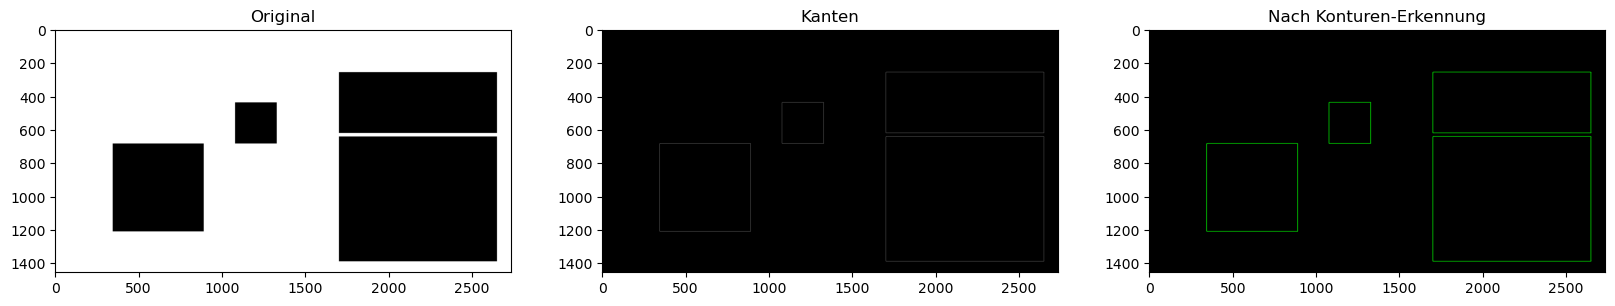

In [11]:
img = cv.imread('./img/segment003.jpg', cv.IMREAD_GRAYSCALE)
plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.title('Original'); plt.imshow(img, cmap='gray')

# Kantenerkennung
edges = cv.Canny(img, 30, 200)
plt.subplot(1,3,2); plt.title('Kanten'); plt.imshow(edges, cmap='gray')

# Konturenerkennung
contours, hierarchy=cv.findContours(edges,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_NONE)
cont = cv.cvtColor(edges, cv.COLOR_GRAY2RGB)
cont = cv.drawContours(cont, contours, contourIdx=-1, color=(0,255,0), thickness=2, lineType=cv.LINE_AA, hierarchy=hierarchy)
plt.subplot(1,3,3); plt.title('Nach Konturen-Erkennung'); plt.imshow(cont); plt.show()


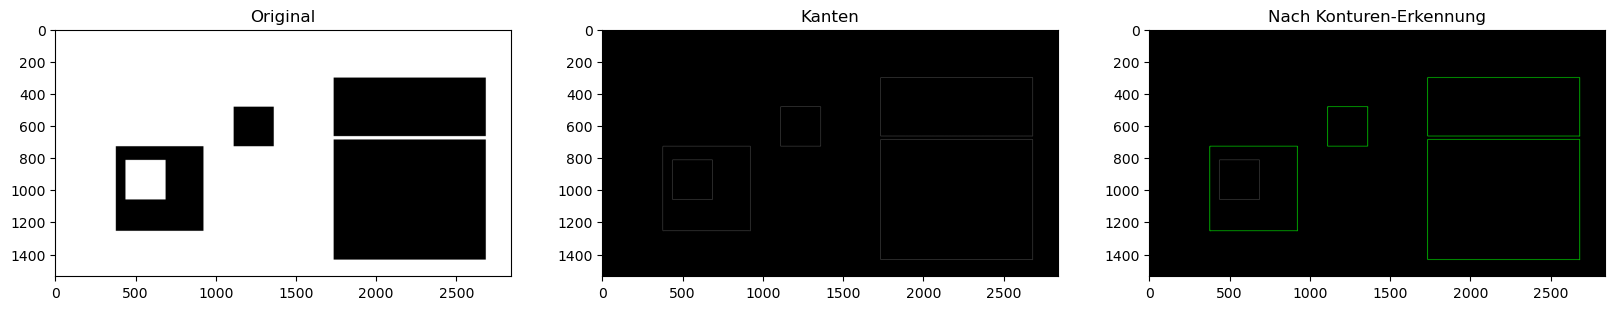

In [12]:
img = cv.imread('./img/segment004.jpg', cv.IMREAD_GRAYSCALE)
plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.title('Original'); plt.imshow(img, cmap='gray')

# Kantenerkennung
edges = cv.Canny(img, 30, 200)
plt.subplot(1,3,2); plt.title('Kanten'); plt.imshow(edges, cmap='gray')

# Konturenerkennung
contours, hierarchy=cv.findContours(edges,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_NONE)
cont = cv.cvtColor(edges, cv.COLOR_GRAY2RGB)
cont = cv.drawContours(cont, contours, contourIdx=-1, color=(0,255,0), thickness=2, lineType=cv.LINE_AA, hierarchy=hierarchy)
plt.subplot(1,3,3); plt.title('Nach Konturen-Erkennung'); plt.imshow(cont); plt.show()

In dieser Form von findContours werden ausschließlich die äußeren Konturen betrachtet. Dies lässt sich durch die Einstellung des Retrieve-Modes einstellen: 
- RETR_EXTERNAL: nur äußere Kanten (unter Berücksichtigung der Hierarchie der Objekte)
- RETR_LIST: alle Konturen ohne Betrachtung der Hierarchie

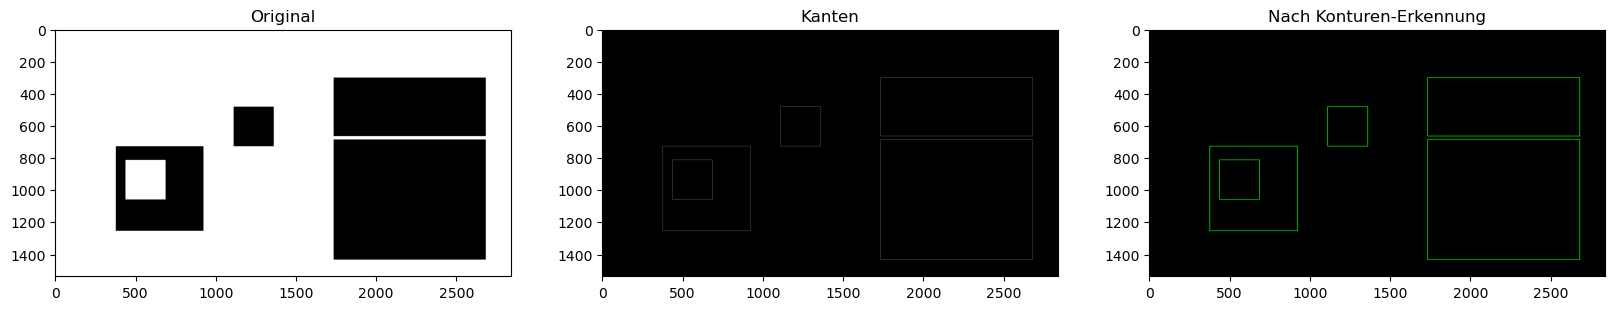

In [13]:
img = cv.imread('./img/segment004.jpg', cv.IMREAD_GRAYSCALE)
plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.title('Original'); plt.imshow(img, cmap='gray')

# Kantenerkennung
edges = cv.Canny(img, 30, 200)
plt.subplot(1,3,2); plt.title('Kanten'); plt.imshow(edges, cmap='gray')

# Konturenerkennung
contours, hierarchy=cv.findContours(edges,cv.RETR_LIST,cv.CHAIN_APPROX_NONE)
cont = cv.cvtColor(edges, cv.COLOR_GRAY2RGB)
cont = cv.drawContours(cont, contours, contourIdx=-1, color=(0,255,0), thickness=2, lineType=cv.LINE_AA, hierarchy=hierarchy)
plt.subplot(1,3,3); plt.title('Nach Konturen-Erkennung'); plt.imshow(cont); plt.show()

## Erkenne Templates mithilfe von Konturen

länge2


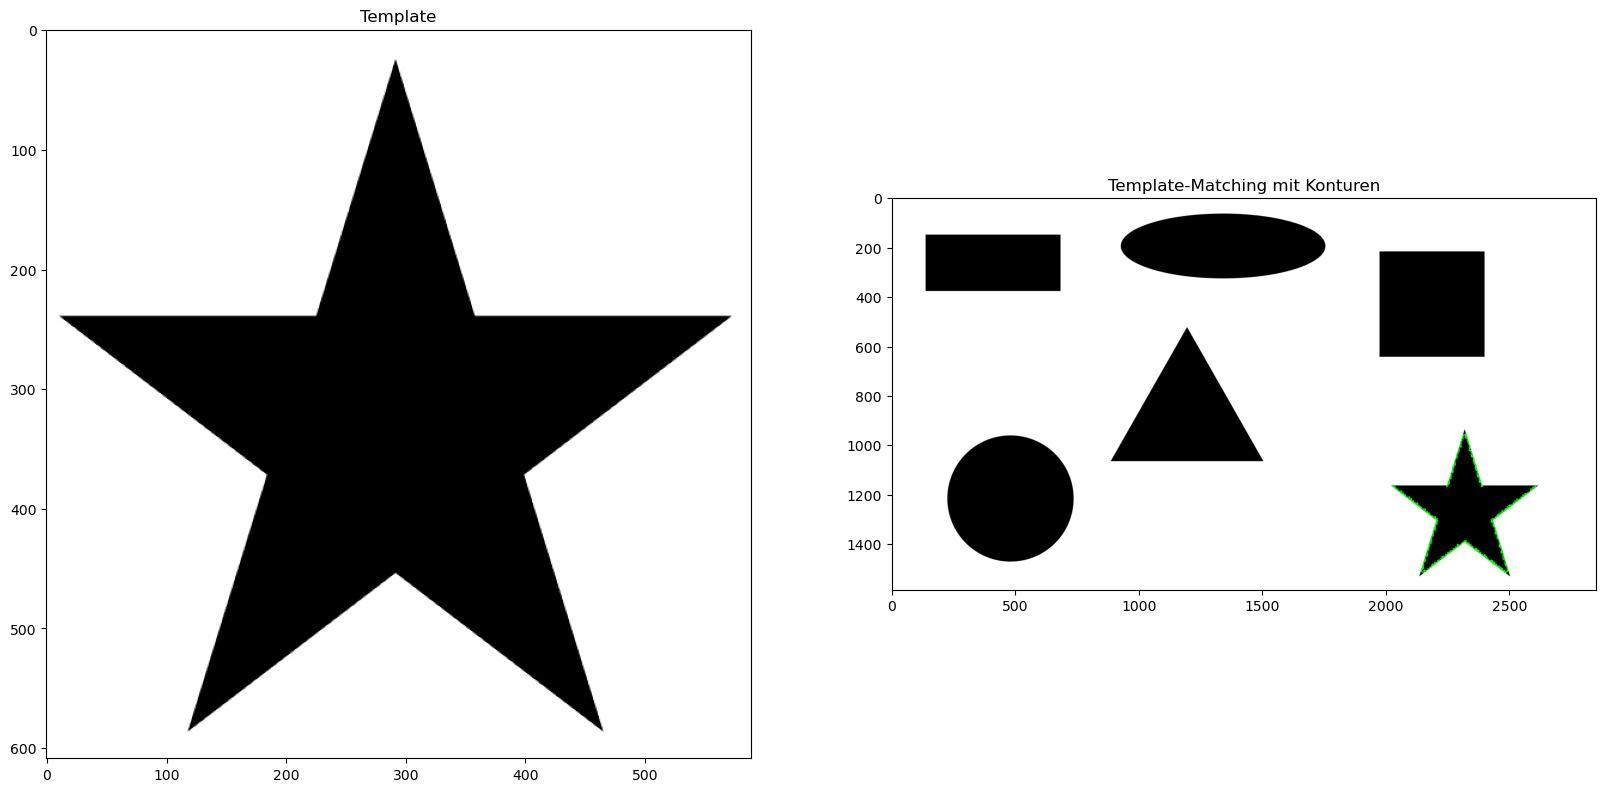

In [19]:
template = cv.imread('./img/segment_stern.jpg', cv.IMREAD_GRAYSCALE)
target = cv.imread('./img/segment005.jpg', cv.IMREAD_GRAYSCALE)

# wende Threshold an, falls Bilder bisher nicht binär (Schwarz-Weiß)
ret, thresh_temp = cv.threshold(template, 127,255,0)
ret, thresh_target = cv.threshold(target, 127,255,0)

# erkenne Konturen im Template
contours, hierachy = cv.findContours(thresh_temp, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
# sortiere Konturen nach Größe und verwende die zweit-größte Kontur (erst-größte wäre der Bildrahmen)
sorted_contours = sorted(contours, key=cv.contourArea, reverse=True)
template_contour = sorted_contours[1]

print("länge" + str(len(sorted_contours)))

# erkenne Konturen im Bild
contours, hierachy = cv.findContours(target, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
# iteriere über Konturen und vergleiche sie mit der Template-Kontur
closest_match = 0.25
closest_contour = []
for c in contours: 
    match = cv.matchShapes(template_contour, c, 1, 0.0)    
    if match < closest_match:
        #print('Übereinstimmung mit ', match)
        closest_contour = c        
        closest_match = match    

target = cv.cvtColor(target, cv.COLOR_GRAY2RGB) 
cv.drawContours(target, closest_contour, -1, (0,255,0),3)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.title('Template'); plt.imshow(template, cmap='gray'); 
plt.subplot(1,2,2); plt.title('Template-Matching mit Konturen'); plt.imshow(target); plt.show()


## Geometrische Figuren anhand von Konturen erkennen

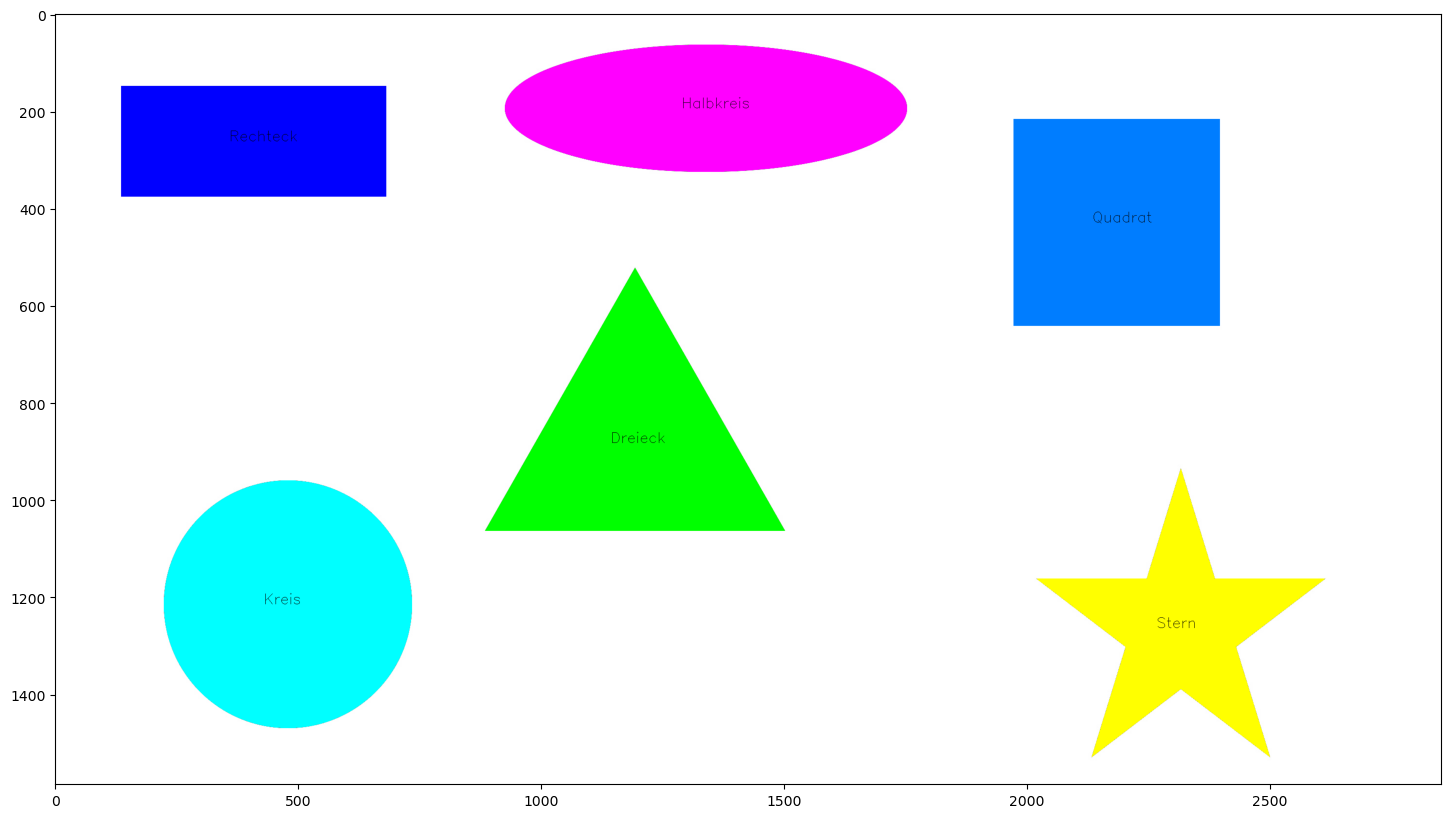

In [25]:
img = cv.imread('./img/segment005.jpg')
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
ret, img_gray = cv.threshold(img_gray,127,255,1)

# finde Konturen
contours,hierarchy=cv.findContours(img_gray.copy(),cv.RETR_LIST,cv.CHAIN_APPROX_NONE)
for c in contours:
    # finde entsprechende Polygone, die zur Form passen
    approx = cv.approxPolyDP(c, 0.01 * cv.arcLength(c, True), True)
    if len(approx) == 3: 
        shape_name = 'Dreieck'
        cv.drawContours(img,[c],0,(0,255,0),-1)
        M = cv.moments(c)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        cv.putText(img,shape_name,(cx-50,cy),cv.FONT_HERSHEY_SIMPLEX,1,(0,0,0),1)
    elif len(approx) == 4:
        x,y,w,h = cv.boundingRect(c)
        M = cv.moments(c)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        if abs(w-h) <= 3:
            shape_name = 'Quadrat'
            cv.drawContours(img,[c],0,(0,125,255),-1)
            cv.putText(img,shape_name,(cx-50,cy),cv.FONT_HERSHEY_SIMPLEX,1,(0,0,0),1)
        else:
            shape_name = 'Rechteck'
            cv.drawContours(img,[c],0,(0,0,255),-1)
            M = cv.moments(c)
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            cv.putText(img,shape_name,(cx-50,cy),cv.FONT_HERSHEY_SIMPLEX,1,(0,0,0),1)
    elif len(approx) == 10:
        shape_name = 'Stern'
        cv.drawContours(img,[c],0,(255,255,0),-1)
        M = cv.moments(c)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        cv.putText(img,shape_name,(cx-50,cy),cv.FONT_HERSHEY_SIMPLEX,1,(0,0,0),1)
    elif len(approx) == 12:
        shape_name = 'Halbkreis'
        cv.drawContours(img,[c],0,(255,0,255),-1)
        M = cv.moments(c)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        cv.putText(img,shape_name,(cx-50,cy),cv.FONT_HERSHEY_SIMPLEX,1,(0,0,0),1)
    elif len(approx) >= 15:
        shape_name = 'Kreis'
        cv.drawContours(img,[c],0,(0,255,255),-1)
        M = cv.moments(c)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        cv.putText(img,shape_name,(cx-50,cy),cv.FONT_HERSHEY_SIMPLEX,1,(0,0,0),1)
    else:
        shape_name = 'Unbekannt'
        cv.drawContours(img,[c],0,(255,0,0),-1)
        M = cv.moments(c)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        cv.putText(img,shape_name,(cx-50,cy),cv.FONT_HERSHEY_SIMPLEX,1,(0,0,0),1)

plt.figure(figsize=(20,10)); plt.imshow(img); plt.show()


# Aufgabe: Erweitern Sie die Erkennung geometrische Figuren auf weitere Formen (Stern, Rechteck, ...)